# Tutorial
In this notebook, I review basic usage of our python wrapper.  

## 0. Compile python wrapper
First of all, you need to compile the python wrapper.
It needs C++ compiler, GSL, and Boost library.
Please make sure that yout Boost library has numpy extension since older versions of Boost do not include it.  
After specifying paths for these libarary in Makefile, you can just type

```
$ make pyeclairs
```

Then, the shared library `pyeclairs.so` is created. When you use the wrapper, please place this library to the directory where you run the script or a path where the interpreter can find it.

## 1. Computing power spectra based on RegPT 2loop
The basic feature of this code is computing matter power spectra for arbitrary cosmology. 
This function needs transfer function, which can be passed from a precomputed table or numpy array computed with other codes, e.g., CAMB or CLASS.  
Here, I use CAMB module to create transfer function.

In [1]:
# import necessary modules
import numpy as np
import camb
import pyeclairs

In [2]:
# cosmological parameters
params = {"H0": 67.27,
          "Omega_m": 0.3156,
          "Omega_b": 0.04917,
          "ns": 0.9645,
          "As": 2.2e-9,
          "k_pivot": 0.05,
          "z": 1.0
          }

In [3]:
# setting cosmological parameters to pass CAMB module
pars = camb.CAMBparams()
H0 = params["H0"]
ombh2 = params["Omega_b"]*(H0/100.0)**2
omch2 = (params["Omega_m"]-params["Omega_b"])*(H0/100.0)**2
As = params["As"]
ns = params["ns"]
k_pivot = params["k_pivot"]

pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.06, omk=0.0)
pars.set_dark_energy()  # lambda CDM assumed
pars.InitPower.set_params(As=As, ns=ns, r=0, pivot_scalar=k_pivot)
pars.set_matter_power(redshifts=[params["z"], 0.0], kmax=50.0)
pars.NonLinear = camb.model.NonLinear_none
pars.DoLensing = False

In [4]:
# main calculation for CAMB
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=11.0, npoints=500)

transfer_result = results.get_matter_transfer_data()
q = transfer_result.transfer_data[0, :, 1]  # wave number [h/Mpc]
Tk = transfer_result.transfer_data[6, :, 1]  # total transfer

q = np.array(q, dtype=np.float64)
Tk = np.array(Tk, dtype=np.float64)

You can skip these calculations if you have already computed transfer function.  
In this case, you should load tabulated data as ndarray with `np.loadtxt`.

In [5]:
# loading pyeclairs module and setting cosmological parameters for python wrapper
spectrum = pyeclairs.pyspectrum()
spectrum.set_cosmology(params, q, Tk)

Then specify the wavenumbers to be output.

In [6]:
# This is main calculation. As it may take time, you can reduce the number of k by speeding up.
k = np.linspace(0.01, 0.3, 30)
Preg2loop = spectrum.calc_RegPT_2loop(k)
print k, Preg2loop

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3 ] [8370.53301717 9148.22482941 7494.65397333 5763.95189106 4688.30742112
 4107.52877961 3649.33574558 3111.43204449 2554.53899751 2120.78917718
 1854.86677267 1704.15075428 1574.18299082 1417.57910378 1247.61099714
 1099.79606091  995.33498175  925.58340503  868.92301217  809.60885821
  743.4250724   681.5876298   629.69002623  588.50611162  554.08281002
  520.61663791  487.34961521  454.19822006  423.97506436  396.54285879]


Now the power spectrum is stored as ndarray `Preg2loop`.  
Let's plot it with matplotlib.

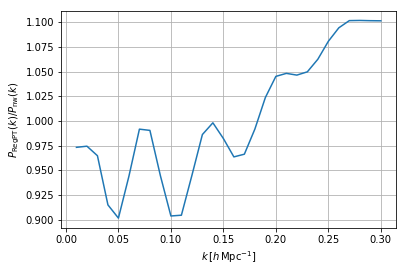

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

Pnowiggle = spectrum.calc_no_wiggle(k)
plt.plot(k, Preg2loop/Pnowiggle)
plt.xlabel(r"$k \, [h \, \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P_\mathrm{RegPT} (k) / P_\mathrm{nw} (k)$")
plt.grid()

## 2. Computing power spectra based on IR-resummed EFT
The module also provides the calculation with smoothed linear power spectrum.  
Here, I will show how to construct power spectrum based on IR-resummed EFT at 2-loop level.

In [8]:
P2loop = spectrum.calc_SPT_2loop(k)
P1loop = spectrum.calc_SPT_1loop(k)
Plin = spectrum.calc_linear(k)

# create another class for smoothed spectra
smoothed_spectrum = pyeclairs.pyspectrum()
params["smoothing"] = True
smoothed_spectrum.set_cosmology(params, q, Tk)

# spectra with smoothed linear power spectrum
P2loop_nw = smoothed_spectrum.calc_SPT_2loop(k)
P1loop_nw = smoothed_spectrum.calc_SPT_1loop(k)
Plin_nw = smoothed_spectrum.calc_linear(k)

In [9]:
dP2loop = P2loop-P1loop
dP1loop = P1loop-Plin

dP2loop_nw = P2loop_nw-P1loop_nw
dP1loop_nw = P1loop_nw-Plin_nw

dP2loop_w = dP2loop-dP2loop_nw
dP1loop_w = dP1loop-dP1loop_nw
Plin_w = Plin-Plin_nw

In [10]:
# determine free parameters in IR-resummed EFT
alpha1 = 1.0
alpha2 = 5.0
Sigma = 4.0

C1 = k**2*Sigma**2*(1.0+alpha1*k**2) + 0.5*k**4*Sigma**4
C2 = k**2*Sigma**2*(1.0+alpha2*k**2)


Pnw = (1.0+alpha1*k**2)*Plin_nw + (1.0+alpha2*k**2)*dP1loop_nw + dP2loop_nw
Pw = np.exp(-k**2*Sigma**2)*((1.0+alpha1*k**2+C1)*Plin_w + (1.0+alpha2*k**2+C2)*dP1loop_w + dP2loop_w)

P_IREFT = Pw + Pnw

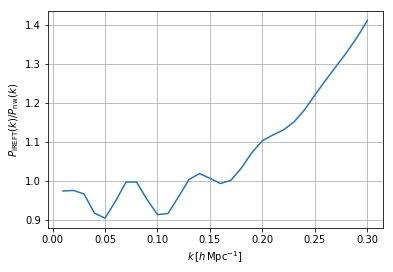

In [11]:
# plot results
plt.plot(k, P_IREFT/Pnowiggle)
plt.xlabel(r"$k \, [h \, \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P_\mathrm{IREFT} (k) / P_\mathrm{nw} (k)$")
plt.grid()